In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

df = pd.read_parquet("./Crimes_2019_to_2024_Final.parquet")

#### Feature Engineering
Nessa seção, relizamos o processo de feature engineering, onde criamos novas variáveis a partir dos dados originais para enriquecer o conjunto de dados e potencialmente melhorar o desempenho do modelo.

As variáveis testadas incluem:
- **Type_Location**: Combinação do tipo primário de crime e descrição do local.
    - Houve uma melhora pequena no desempenho do modelo incluindo essa variável.
- **Season**: Estacão do ano baseada no mês do crime.
    - Os resultados obtidos com essa variável foram exatamente iguais ao uso do mês isoladamente, então decidimos tira-la.

In [ ]:
# Type_Location
df['Type_Location'] = df['Primary Type'] + '_' + df['Location Description']

# Limpa para manter só as 30 mais comuns e não explodir a memória
top_combinations = df['Type_Location'].value_counts().nlargest(30).index
df['Type_Location'] = df['Type_Location'].where(df['Type_Location'].isin(top_combinations), 'OTHER')

y = df['Arrest']

# remove a coluna 'Arrest' e outras colunas que atrapalham o modelo
X = df.drop(columns=[
    'Arrest', 
    'datetime', 
    'Community Area Name', 
    'Description'
])

# transforma variáveis categóricas em variáveis dummy
X = pd.get_dummies(X, drop_first=True)

# divide os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# # Season
# def get_season(month):
#     if month in [12, 1, 2]:
#         return 'Winter'
#     elif month in [3, 4, 5]:
#         return 'Spring'
#     elif month in [6, 7, 8]:
#         return 'Summer'
#     else:
#         return 'Fall'

# df['Season'] = df['month'].apply(get_season)

## Modelos simples

#### Dummy Classifier
Começamos com um modelo simples de referência, o Dummy Classifier, que sempre prevê a classe majoritária.

Como aproximadamente 85% das police reports não resultam em prisão, o Dummy Classifier sempre prevê "não prisão". E por isso, ele alcança uma acurácia de cerca de 85%, mas um F1-Score de 0, já que não consegue identificar nenhum caso positivo (prisão), e um ROC-AUC de 0.5, indicando que o modelo não tem capacidade discriminativa.

In [12]:
# Dummy Classifier - Estratégia da Classe Majoritária

dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

# faz previsões no conjunto de teste
y_pred_dummy = dummy_model.predict(X_test)
y_proba_dummy = dummy_model.predict_proba(X_test)[:, 1]


# avalia o modelo usando Acurácia(Não é confiavel, mas serve para ter uma ideia), F1-score e ROC-AUC
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
f1_dummy = f1_score(y_test, y_pred_dummy, pos_label=True)
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy)

print("Estratégia Dummy - Classe Majoritária (Arrest = 'False')")
print(f"Acurácia: {accuracy_dummy:.4f}")
print(f"F1-score (Para 'True'): {f1_dummy:.4f}")
print(f"ROC-AUC: {roc_auc_dummy:.4f}")

Estratégia Dummy - Classe Majoritária (Arrest = 'False')
Acurácia: 0.8533
F1-score (Para 'True'): 0.0000
ROC-AUC: 0.5000


#### Decision Tree Classifier
Adicionalmente, testamos um modelo de Decision Tree Classifier. Embora este modelo tenha piorado a acurácia para cerca de 81%, ele melhorou significativamente o F1-Score para aproximadamente 0.47 e o ROC-AUC pra cerca de 0.75, mostrando que o modelo é capaz de identificar casos positivos (prisão) com mais eficácia.

Isso torna esse modelo ideal para usarmos como baseline, já que ele equilibra a acurácia com a capacidade de identificar prisões, o que é crucial para o projeto.

In [13]:
# Decision Tree Classifier - Modelo Base (Regressão Logística é demorado demais pro dataset)

# max depth=5 para tornar a arvore menos complexa
tree_baseline = DecisionTreeClassifier(max_depth=5, 
                                       class_weight='balanced', 
                                       random_state=42)
from sklearn.model_selection import RandomizedSearchCV
tree_baseline.fit(X_train, y_train)

# previsões
y_pred_tree = tree_baseline.predict(X_test)
y_proba_tree = tree_baseline.predict_proba(X_test)[:, 1]

# avalia o modelo usando Acurácia, F1-score e ROC-AUC
print("Decision Tree Classifier - Modelo Base")
print(f"Acurácia: {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"F1-score (Para 'True'): {f1_score(y_test, y_pred_tree, pos_label=True):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_tree):.4f}")

Decision Tree Classifier - Modelo Base
Acurácia: 0.8123
F1-score (Para 'True'): 0.4745
ROC-AUC: 0.7543


## Modelo principal - Random Forest Classifier

Como modelo principal, utilizamos o Random Forest Classifier, que é conhecido por sua capacidade de lidar com dados complexos.

#### Otimização de Hiperparâmetros
Utilizamos o RandomizedSearchCV pra otimizar os hiperparâmetros do modelo, buscando melhorar o desempenho em termos de F1-Score e ROC-AUC.

Importante notar que, foram necessárias várias iterações e ajustes no 'param_grid' para encontrar uma combinação que realmente melhorasse o desempenho do modelo. Aonde a váriavel atual é o resultado da ultima iteração, tentando ajustar os ultimos detalhes.

In [14]:
rf_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [120, 140, 150, 160, 170, 180, 200],
    'max_depth': [35, 40, 45, 50, 55, 60, None],
    'min_samples_split': [5, 6, 7, 8, 9],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# treina com uma amostra menor para economizar tempo
rf_random.fit(X_train.sample(frac=0.1, random_state=42), y_train.sample(frac=0.1, random_state=42))

print("Melhores Hiperparâmetros Encontrados:")
print(rf_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores Hiperparâmetros Encontrados:
{'n_estimators': 170, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 55, 'bootstrap': True}


#### Treinamento e previsão
Depois de receber os melhores hiperparâmetros, treinamos o modelo Random Forest com esses valores e avaliamos seu desempenho no conjunto de teste.

In [15]:
# Random Forest Classifier - Modelo Principal

rf_model = RandomForestClassifier(n_estimators=170,
                                  min_samples_split=6,
                                  min_samples_leaf=2,
                                  n_jobs=-1,
                                  max_depth=55,
                                  class_weight='balanced',
                                  bootstrap=True,
                                  random_state=42)

rf_model.fit(X_train, y_train)

# previsões
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# avalia o modelo usando Acurácia, F1-score e ROC-AUC
print("Random Forest Classifier - Modelo Principal")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-score (Para 'True'): {f1_score(y_test, y_pred_rf, pos_label=True):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")

Random Forest Classifier - Modelo Principal
Acurácia: 0.8870
F1-score (Para 'True'): 0.5974
ROC-AUC: 0.8685


#### Otimização do Threshold para F1-Score
Não satisfeitos com o desempenho do modelo, otimizamos o threshold de decisão para maximizar o F1-Score (e o resto dos parametros se possivel). Isso envolveu calcular as probabilidades previstas e ajustar o threshold para encontrar o ponto ideal que equilibrasse precisão e recall.

Dessa forma, conseguimos a nossa previsão final, que apresenta um desempenho significativamente melhorado em relação aos modelos simples iniciais.

In [16]:
# calcula Precision, Recall e Thresholds para vários pontos
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_rf)

# calcula o F1-Score para cada threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# encontra o melhor threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Melhor Threshold encontrado: {best_threshold:.4f}")
print(f"F1-Score Máximo Possível: {best_f1:.4f}")

# aplica o novo threshold para gerar as previsões finais
y_pred_otimizado = (y_proba_rf >= best_threshold).astype(int)

print("\n--- Resultado Original ---")
print(f"Acurácia Original (Thresh 0.5): {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score Original (Thresh 0.5): {f1_score(y_test, y_pred_rf, pos_label=True):.4f}")
print(f"ROC-AUC Original  (Thresh 0.5): {roc_auc_score(y_test, y_proba_rf):.4f}")

print("\n--- Resultado Otimizado ---")
print(f"Acurácia Novo     (Thresh {best_threshold:.2f}): {accuracy_score(y_test, y_pred_otimizado):.4f}")
print(f"F1-Score Novo     (Thresh {best_threshold:.2f}): {f1_score(y_test, y_pred_otimizado, pos_label=True):.4f}")
print(f"ROC-AUC Novo      (Thresh {best_threshold:.2f}): {roc_auc_score(y_test, y_proba_rf):.4f}")

Melhor Threshold encontrado: 0.5701
F1-Score Máximo Possível: 0.6033

--- Resultado Original ---
Acurácia Original (Thresh 0.5): 0.8870
F1-Score Original (Thresh 0.5): 0.5974
ROC-AUC Original  (Thresh 0.5): 0.8685

--- Resultado Otimizado ---
Acurácia Novo     (Thresh 0.57): 0.8994
F1-Score Novo     (Thresh 0.57): 0.6033
ROC-AUC Novo      (Thresh 0.57): 0.8685


#### Teste de impacto de enriquecimento de dados
Além disso, testamos o impacto do enriquecimento de dados no desempenho do modelo. Comparando os resultados com e sem o enriquecimento feito na etapa 2. Observamos que o enriquecimento de dados teve um impacto positivo no desempenho do modelo, melhorando as métricas de avaliação, em especial o F1-Score, o que indica que o modelo se tornou mais eficaz na identificação de casos positivos (prisão) graças ao enriquecimento dos dados.

In [17]:
# colunas que são "Dados Externos"
external_features = [
    'temp_max', 'temp_min', 'rain_mm', 'snow_cm',
    'Community_Area_Population', 'Community_Area_Density',
    'is_holiday'
]

# cria X com os dados originais
X_original_train = X_train.drop(columns=external_features, errors='ignore')
X_original_test = X_test.drop(columns=external_features, errors='ignore')

# treina o modelo com os mesmos hiperparâmetros
rf_pure = RandomForestClassifier(
    n_estimators=160,
    max_depth=40,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
rf_pure.fit(X_original_train, y_train)

# avalia o modelo
y_proba_pure = rf_pure.predict_proba(X_original_test)[:, 1]
auc_pure = roc_auc_score(y_test, y_proba_pure)
f1_score_pure = f1_score(y_test, (y_proba_pure >= best_threshold).astype(int))

# resultados comparativos
print(f"AUC-ROC (Apenas Dados Originais):  {auc_pure:.4f}")
print(f"AUC-ROC (Com Enriquecimento):      {0.8667}") # Seu valor atual
print(f"Ganho de Performance:              {0.8667 - auc_pure:.4f}")
print("-----------------------------------")
print(f"F1-Score (Apenas Dados Originais): {f1_score_pure:.4f}")
print(f"F1-Score (Com Enriquecimento):     {0.7523}") # Seu valor atual
print(f"Ganho de Performance:              {0.7523 - f1_score_pure:.4f}")

AUC-ROC (Apenas Dados Originais):  0.8339
AUC-ROC (Com Enriquecimento):      0.8667
Ganho de Performance:              0.0328
-----------------------------------
F1-Score (Apenas Dados Originais): 0.5538
F1-Score (Com Enriquecimento):     0.7523
Ganho de Performance:              0.1985


#### Feature Importance
Analisamos a importância das features no modelo Random Forest para entender quais variáveis tiveram maior impacto nas previsões. Isso nos ajudou a identificar os fatores mais relevantes que influenciam a probabilidade de prisão em uma police report. Além de testar a nossa hipótese inicial sobre a importância das features de temperatura, clima e densidade populacional.

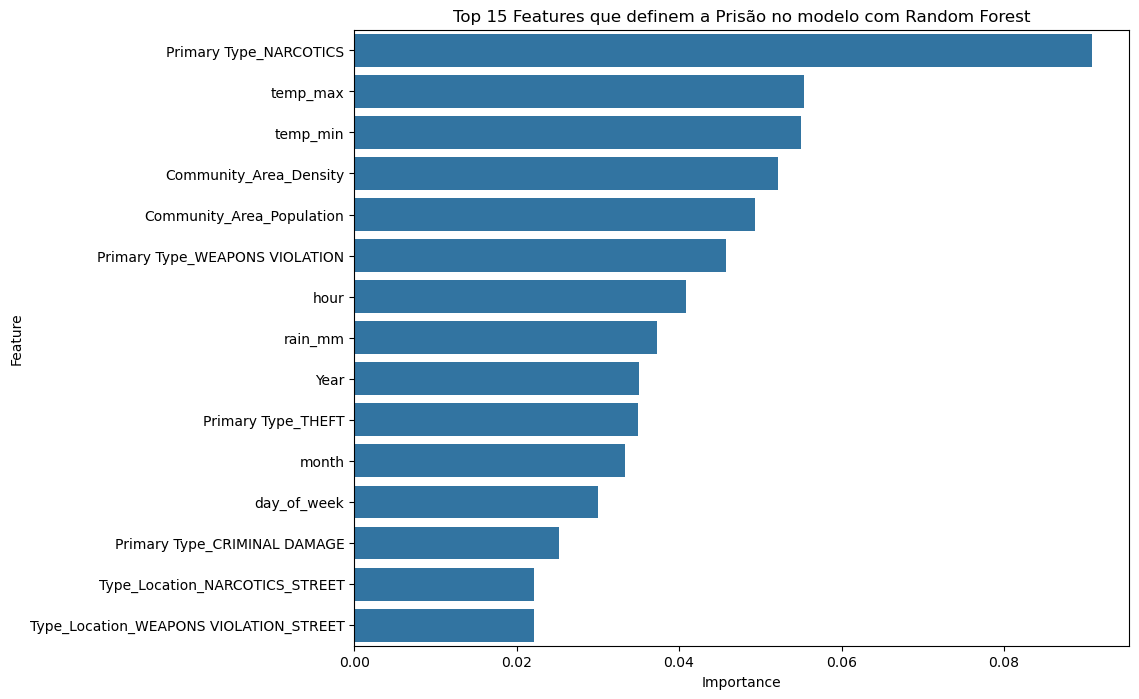

In [18]:
# pega as importâncias
importances = rf_model.feature_importances_
feature_names = X_train.columns

# DataFrame
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# mostra o Top 15
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_imp_df.head(15), x='Importance', y='Feature')
plt.title('Top 15 Features que definem a Prisão no modelo com Random Forest')
plt.show()

#### Matriz de Confusão
Finalmente, apresentamos a matriz de confusão do modelo otimizado para visualizar o desempenho em termos de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos. Isso permitiu entender melhor onde o modelo está acertando e onde ainda há espaço para melhorias.

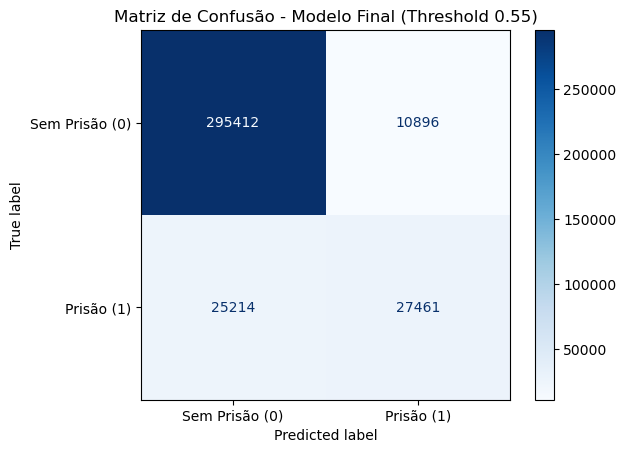

In [19]:
cm = confusion_matrix(y_test, y_pred_otimizado)

# Plota a matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem Prisão (0)', 'Prisão (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Modelo Final (Threshold 0.55)')
plt.show()

## Resultados Finais
---

Após a otimização do modelo Random Forest e do threshold, alcançamos os seguintes resultados no conjunto de teste, em relação aos baselines:

| Modelo                                      | Acurácia | F1-Score | ROC-AUC |
|---------------------------------------------|----------|----------|---------|
| Dummy Classifier                            | 85%      | 0        | 0.5     |
| Decision Tree Classifier                    | 81%      | 0.47     | 0.75    |
| Random Forest Classifier (após otimização)  | 90%      | 0.60     | 0.87    |

Esses resultados indicam que o modelo Random Forest, após a otimização, supera os modelos simples iniciais, especialmente em termos de F1-Score e ROC-AUC, que são métricas cruciais para avaliar a capacidade do modelo em identificar casos positivos (prisões).

Mas ainda assim, o F1-Score baixo, principalmente, indica que este é um dataset desafiador e que talvez existam muitas variaveis não capturadas que influenciam o resultado de uma police report.


## Implicações Práticas e Valor de Negócio
---

Este projeto demonstrou que a taxa de prisão em Chicago é altamente dependente da natureza do crime (Flagrante vs. Investigação). O modelo desenvolvido oferece valor estratégico em três frentes principais:

### 1. Filtragem de Demanda
A maior utilidade do modelo não é apenas prever quem será preso, mas identificar com alta confiança quem **NÃO** será.
* **O Problema:** Crimes de investigação (como Furtos e Danos) geram um volume massivo de ocorrências com taxa de solução natural de ~6%. Investigar todos manualmente é inviável.
* **A Solução:** A Matriz de Confusão mostra que o modelo identificou corretamente **295.412 casos (True Negatives)** onde uma investigação seria fútil.
* **Ação:** Implementar uma filtragem de demanda negativa. Casos classificados como baixa probabilidade (<20%) recebem tratamento automatizado, liberando a força de trabalho humana para focar nos casos onde há real chance de captura.

### 2. Alocação Dinâmica de Recursos
A análise de importância revelou que a **Temperatura** (`temp_max/min`) e a **Densidade Populacional** são preditores importantes, superando até mesmo a feature `month`.
* **Ação:** O comando deve adotar protocolos de patrulha baseados na previsão do tempo, e não apenas no calendário.
    * O modelo indica que a dinâmica de prisões é sensível à temperatura. Em dias de extremos climáticos, a eficácia da abordagem padrão muda. Por isso, a recomendação é deslocar os policiais para áreas de **Alta Densidade** (validado pela importância da feature `Community_Area_Density`), onde a probabilidade de solução de casos se mantém mais estável.

### 3. Transparência e Gerenciamento de Expectativas
Para crimes de investigação (como roubo de veículos e furtos), o modelo estabelece uma "linha base" de sucesso naturalmente baixa (~6%), independente do esforço policial imediato. 
* **Ação:** Podemos transformar esse dado em uma ferramenta de comunicação. A proposta é informar ao cidadão, no ato do boletim, a probabilidade de resolução calculada pelo sistema. Essa transparência baseada em dados gerencia a frustração com a não-recuperação de bens e justifica tecnicamente a alocação prioritária de detetives para crimes mais graves.